<a href="https://colab.research.google.com/github/AviShtarkberg/Art_Stlyle_Classification/blob/main/all_shapes_ResNet_fine_tunning_shape_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %% 1. Mount Drive + imports
from google.colab import drive
drive.mount('/content/drive')

!pip install albumentations --quiet
import os, random, warnings, cv2, math, time
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

import torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models
from albumentations import Compose, Resize, ShiftScaleRotate, RandomBrightnessContrast, GaussianBlur, CoarseDropout, Lambda
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings("ignore")
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Mounted at /content/drive
Device: cuda


In [2]:
# %% 2. Hyper-params & paths
SHAPE_SOURCES = {
    "shape7":  ("/content/shape7_labels_all.csv", "/content/drive/MyDrive/shapes/shape7"),
    "shape9":  ("/content/shape9_scores.csv",     "/content/drive/MyDrive/shapes/shape9"),
    "shape14": ("/content/shape14_scores.xlsx",   "/content/drive/MyDrive/shapes/shape14"),
    "shape18": ("/content/shape18_scores.csv",    "/content/drive/MyDrive/shapes/shape18"),
}

IMG_SIZE   = 128
BATCH_SIZE = 32
EPOCHS     = 60
LR         = 3e-4
PATIENCE   = 10
TOL        = 1          # ±1 tolerance for accuracy


In [3]:
# %% 3. Smart auto-crop
def smart_center_crop(img: np.ndarray, thr=20):
    ys, xs = np.where(img > thr)
    if xs.size == 0: return img
    x0, x1, y0, y1 = xs.min(), xs.max(), ys.min(), ys.max()
    side = max(x1 - x0, y1 - y0) + 2
    cx, cy = (x0 + x1)//2, (y0 + y1)//2
    half = side//2
    x0, x1, y0, y1 = cx-half, cx+half, cy-half, cy+half
    pad_x0, pad_y0 = max(-x0,0), max(-y0,0)
    pad_x1, pad_y1 = max(x1-img.shape[1]+1,0), max(y1-img.shape[0]+1,0)
    if pad_x0+pad_x1+pad_y0+pad_y1:
        img = np.pad(img, ((pad_y0,pad_y1),(pad_x0,pad_x1)), constant_values=0)
        y0+=pad_y0; y1+=pad_y0; x0+=pad_x0; x1+=pad_x0
    return img[y0:y1+1, x0:x1+1]

class SmartCrop:
    def __init__(self, thr=20): self.thr=thr
    def __call__(self, img, **kw): return smart_center_crop(img, self.thr)


In [4]:
# %% 4. Dataset & transforms
train_tf = Compose([
    Lambda(image=SmartCrop(20)),
    Resize(IMG_SIZE, IMG_SIZE),
    ShiftScaleRotate(0.05, 0.05, 10, border_mode=cv2.BORDER_CONSTANT, value=0, p=0.8),
    RandomBrightnessContrast(0.2, 0.2, p=0.5),
    GaussianBlur(blur_limit=3, p=0.3),
    CoarseDropout(max_holes=4, max_height=16, max_width=16,
                  min_holes=1, min_height=8, min_width=8,
                  fill_value=0, p=0.3),
    ToTensorV2()
])
val_tf = Compose([
    Lambda(image=SmartCrop(20)),
    Resize(IMG_SIZE, IMG_SIZE),
    ToTensorV2()
])

class ShapeDataset(Dataset):
    def __init__(self, df, tf):
        self.df = df.reset_index(drop=True)
        self.tf = tf
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = cv2.imread(row.img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            img = np.zeros((200, 200), np.uint8)
        img = self.tf(image=img)["image"].float() / 255.0
        return img, torch.tensor(row.label, dtype=torch.float32)


In [5]:
# %% 5. Model
class ResNet18Reg(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.backbone.conv1 = nn.Conv2d(1,64,7,2,3,bias=False)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features,1)
    def forward(self,x): return self.backbone(x).squeeze(1)


In [6]:

# %% 6. Metrics
mae = lambda p,t: torch.mean(torch.abs(p-t)).item()
def acc_std(p,t): return (torch.round(p).int()==t.int()).float().mean().item()*100
def acc_tol(p,t, tol=TOL): return (torch.abs(torch.round(p)-t)<=tol).float().mean().item()*100


In [7]:
# %% 7. Train one fold
from tqdm.notebook import tqdm
from torch.utils.data import WeightedRandomSampler, DataLoader

def run_fold(train_idx, val_idx, full_df, fold_id):
    # --- split data
    train_df, val_df = full_df.iloc[train_idx], full_df.iloc[val_idx]

    # --- weighted sampler to offset label imbalance
    counts  = train_df.label.value_counts().sort_index().values
    weights = 1.0 / (counts + 1e-6)
    sample_w = train_df.label.apply(lambda l: weights[int(l) - 1]).values
    sampler  = WeightedRandomSampler(sample_w, len(sample_w), replacement=True)

    # --- loaders (note: ShapeDataset now takes only df + transform)
    train_loader = DataLoader(
        ShapeDataset(train_df, train_tf),
        batch_size=BATCH_SIZE,
        sampler=sampler,
        num_workers=2
    )
    val_loader = DataLoader(
        ShapeDataset(val_df, val_tf),
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2
    )

    # --- model, optimiser, scheduler
    model = ResNet18Reg().to(device)
    for n, p in model.backbone.named_parameters():
        p.requires_grad = n.startswith("layer4") or n.startswith("fc")
    opt  = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
    sch  = optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min",
                                               factor=0.5, patience=3,
                                               min_lr=1e-6, verbose=False)
    loss_fn = nn.SmoothL1Loss(beta=1.0)

    # --- training loop
    best_mae, patience = 1e9, 0
    train_losses, val_maes = [], []

    for epoch in range(1, EPOCHS + 1):
        model.train()
        running = 0.0
        for x, y in tqdm(train_loader,
                         desc=f"Fold {fold_id} | Epoch {epoch}/{EPOCHS}",
                         leave=False):
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            out  = model(x)
            loss = loss_fn(out, y)
            loss.backward()
            opt.step()
            running += loss.item() * x.size(0)

        epoch_loss = running / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # --- validation
        model.eval()
        preds, targs = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                preds.append(model(x).cpu())
                targs.append(y.cpu())
        preds = torch.cat(preds)
        targs = torch.cat(targs)
        v_mae = mae(preds, targs)
        val_maes.append(v_mae)
        sch.step(v_mae)

        print(f"Epoch {epoch:02d} | Train Loss: {epoch_loss:.4f} "
              f"| Val MAE: {v_mae:.4f} | Patience: {patience}")

        # --- early stopping
        if v_mae < best_mae - 1e-3:
            best_mae, patience = v_mae, 0
            torch.save(model.state_dict(), f"/content/best_fold{fold_id}.pth")
        else:
            patience += 1
            if patience >= PATIENCE:
                break

    # --- reload best weights
    model.load_state_dict(torch.load(f"/content/best_fold{fold_id}.pth",
                                     map_location=device))
    model.eval()
    preds, targs = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            preds.append(model(x).cpu())
            targs.append(y.cpu())
    preds, targs = torch.cat(preds), torch.cat(targs)

    # --- store logs for later visualisation
    model._train_logs = {
        "train_loss": train_losses,
        "val_mae":     val_maes,
        "val_targets": targs,
        "val_preds":   preds
    }

    return mae(preds, targs), acc_std(preds, targs), acc_tol(preds, targs), model


In [8]:
# %% 8. 5-fold CV with held-out test set (merge four shape sets)
from sklearn.model_selection import train_test_split

frames = []
for shape_name, (score_file, img_dir) in SHAPE_SOURCES.items():
    if score_file.lower().endswith((".xls", ".xlsx")):
        df_shape = pd.read_excel(score_file)
    else:
        df_shape = pd.read_csv(score_file, encoding="utf-8")

    # absolute path to the PNG for each child_id
    df_shape["img_path"] = df_shape["child_id"].apply(
        lambda cid: os.path.join(img_dir, f"{cid}.png")
    )
    df_shape = df_shape[df_shape["img_path"].apply(os.path.exists)]
    frames.append(df_shape)

df = pd.concat(frames, ignore_index=True)
print("Total samples:", len(df))

# ===== NEW: Split off test set first =====
df_trainval, df_test = train_test_split(
    df, test_size=0.2, stratify=df.label, random_state=SEED
)
print(f"Train+Val: {len(df_trainval)} | Test: {len(df_test)}")

# ===== Run 5-fold CV on train+val only =====
skf = StratifiedKFold(5, shuffle=True, random_state=SEED)

mae_list, std_list, tol_list = [], [], []
fold_models = []

for fold, (tr, va) in enumerate(skf.split(df_trainval, df_trainval.label), 1):
    m, s, t, model = run_fold(tr, va, df_trainval, fold)  # Note: using df_trainval
    mae_list.append(m); std_list.append(s); tol_list.append(t); fold_models.append(model)
    print(f"Fold{fold}: MAE {m:.3f} | ±0 {s:.1f}% | ±{TOL} {t:.1f}%")

print(f"\n5-fold avg MAE {np.mean(mae_list):.3f}±{np.std(mae_list):.3f}")
print(f"5-fold avg ±0 {np.mean(std_list):.1f}% | ±{TOL} {np.mean(tol_list):.1f}%")

best_model = fold_models[np.argmin(mae_list)]

Total samples: 3557
Train+Val: 2845 | Test: 712


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s]


Fold 1 | Epoch 1/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 01 | Train Loss: 1.0671 | Val MAE: 0.9656 | Patience: 0


Fold 1 | Epoch 2/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 02 | Train Loss: 0.6055 | Val MAE: 0.8925 | Patience: 0


Fold 1 | Epoch 3/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 03 | Train Loss: 0.5760 | Val MAE: 0.8564 | Patience: 0


Fold 1 | Epoch 4/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 04 | Train Loss: 0.5399 | Val MAE: 0.7707 | Patience: 0


Fold 1 | Epoch 5/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 05 | Train Loss: 0.4724 | Val MAE: 0.8136 | Patience: 0


Fold 1 | Epoch 6/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 06 | Train Loss: 0.4922 | Val MAE: 0.9720 | Patience: 1


Fold 1 | Epoch 7/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 07 | Train Loss: 0.4634 | Val MAE: 0.7845 | Patience: 2


Fold 1 | Epoch 8/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 08 | Train Loss: 0.4237 | Val MAE: 0.9045 | Patience: 3


Fold 1 | Epoch 9/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 09 | Train Loss: 0.3944 | Val MAE: 0.7938 | Patience: 4


Fold 1 | Epoch 10/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.3732 | Val MAE: 0.7704 | Patience: 5


Fold 1 | Epoch 11/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 0.3647 | Val MAE: 0.7312 | Patience: 6


Fold 1 | Epoch 12/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 0.3583 | Val MAE: 0.7347 | Patience: 0


Fold 1 | Epoch 13/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 0.3529 | Val MAE: 0.7445 | Patience: 1


Fold 1 | Epoch 14/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 14 | Train Loss: 0.3497 | Val MAE: 0.7650 | Patience: 2


Fold 1 | Epoch 15/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 0.3514 | Val MAE: 0.7336 | Patience: 3


Fold 1 | Epoch 16/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 16 | Train Loss: 0.3294 | Val MAE: 0.7141 | Patience: 4


Fold 1 | Epoch 17/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 17 | Train Loss: 0.3159 | Val MAE: 0.7678 | Patience: 0


Fold 1 | Epoch 18/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 18 | Train Loss: 0.3140 | Val MAE: 0.7905 | Patience: 1


Fold 1 | Epoch 19/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 19 | Train Loss: 0.3158 | Val MAE: 0.7165 | Patience: 2


Fold 1 | Epoch 20/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 20 | Train Loss: 0.3010 | Val MAE: 0.6951 | Patience: 3


Fold 1 | Epoch 21/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 21 | Train Loss: 0.3103 | Val MAE: 0.7119 | Patience: 0


Fold 1 | Epoch 22/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 22 | Train Loss: 0.3150 | Val MAE: 0.7244 | Patience: 1


Fold 1 | Epoch 23/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 23 | Train Loss: 0.2887 | Val MAE: 0.7219 | Patience: 2


Fold 1 | Epoch 24/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 24 | Train Loss: 0.2827 | Val MAE: 0.7210 | Patience: 3


Fold 1 | Epoch 25/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 25 | Train Loss: 0.2876 | Val MAE: 0.7115 | Patience: 4


Fold 1 | Epoch 26/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 26 | Train Loss: 0.2856 | Val MAE: 0.7545 | Patience: 5


Fold 1 | Epoch 27/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 27 | Train Loss: 0.2781 | Val MAE: 0.7418 | Patience: 6


Fold 1 | Epoch 28/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 28 | Train Loss: 0.2755 | Val MAE: 0.6977 | Patience: 7


Fold 1 | Epoch 29/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 29 | Train Loss: 0.2645 | Val MAE: 0.7028 | Patience: 8


Fold 1 | Epoch 30/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 30 | Train Loss: 0.2686 | Val MAE: 0.7097 | Patience: 9
Fold1: MAE 0.695 | ±0 47.8% | ±1 89.1%


Fold 2 | Epoch 1/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 01 | Train Loss: 1.0028 | Val MAE: 1.2236 | Patience: 0


Fold 2 | Epoch 2/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 02 | Train Loss: 0.6362 | Val MAE: 0.8070 | Patience: 0


Fold 2 | Epoch 3/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 03 | Train Loss: 0.5494 | Val MAE: 0.9306 | Patience: 0


Fold 2 | Epoch 4/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 04 | Train Loss: 0.5164 | Val MAE: 0.9965 | Patience: 1


Fold 2 | Epoch 5/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 05 | Train Loss: 0.4808 | Val MAE: 0.7155 | Patience: 2


Fold 2 | Epoch 6/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 06 | Train Loss: 0.4793 | Val MAE: 0.7466 | Patience: 0


Fold 2 | Epoch 7/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 07 | Train Loss: 0.4310 | Val MAE: 0.7629 | Patience: 1


Fold 2 | Epoch 8/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 08 | Train Loss: 0.4416 | Val MAE: 0.9215 | Patience: 2


Fold 2 | Epoch 9/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 09 | Train Loss: 0.4073 | Val MAE: 0.7846 | Patience: 3


Fold 2 | Epoch 10/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.3982 | Val MAE: 0.7805 | Patience: 4


Fold 2 | Epoch 11/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 0.3870 | Val MAE: 0.7281 | Patience: 5


Fold 2 | Epoch 12/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 0.3872 | Val MAE: 0.7313 | Patience: 6


Fold 2 | Epoch 13/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 0.3515 | Val MAE: 0.6581 | Patience: 7


Fold 2 | Epoch 14/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 14 | Train Loss: 0.3401 | Val MAE: 0.6451 | Patience: 0


Fold 2 | Epoch 15/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 0.3330 | Val MAE: 0.6599 | Patience: 0


Fold 2 | Epoch 16/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 16 | Train Loss: 0.3584 | Val MAE: 0.6808 | Patience: 1


Fold 2 | Epoch 17/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 17 | Train Loss: 0.3319 | Val MAE: 0.8105 | Patience: 2


Fold 2 | Epoch 18/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 18 | Train Loss: 0.3187 | Val MAE: 0.7519 | Patience: 3


Fold 2 | Epoch 19/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 19 | Train Loss: 0.2893 | Val MAE: 0.6760 | Patience: 4


Fold 2 | Epoch 20/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 20 | Train Loss: 0.3183 | Val MAE: 0.7172 | Patience: 5


Fold 2 | Epoch 21/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 21 | Train Loss: 0.2955 | Val MAE: 0.6991 | Patience: 6


Fold 2 | Epoch 22/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 22 | Train Loss: 0.2909 | Val MAE: 0.6537 | Patience: 7


Fold 2 | Epoch 23/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 23 | Train Loss: 0.2827 | Val MAE: 0.6458 | Patience: 8


Fold 2 | Epoch 24/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 24 | Train Loss: 0.2678 | Val MAE: 0.6616 | Patience: 9
Fold2: MAE 0.645 | ±0 49.2% | ±1 91.0%


Fold 3 | Epoch 1/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 01 | Train Loss: 1.0473 | Val MAE: 1.2287 | Patience: 0


Fold 3 | Epoch 2/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 02 | Train Loss: 0.6458 | Val MAE: 0.8678 | Patience: 0


Fold 3 | Epoch 3/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 03 | Train Loss: 0.5379 | Val MAE: 0.8357 | Patience: 0


Fold 3 | Epoch 4/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 04 | Train Loss: 0.5136 | Val MAE: 1.0488 | Patience: 0


Fold 3 | Epoch 5/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 05 | Train Loss: 0.4742 | Val MAE: 0.9191 | Patience: 1


Fold 3 | Epoch 6/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 06 | Train Loss: 0.4830 | Val MAE: 1.0171 | Patience: 2


Fold 3 | Epoch 7/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 07 | Train Loss: 0.4677 | Val MAE: 0.8156 | Patience: 3


Fold 3 | Epoch 8/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 08 | Train Loss: 0.4418 | Val MAE: 0.9423 | Patience: 0


Fold 3 | Epoch 9/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 09 | Train Loss: 0.4204 | Val MAE: 0.9543 | Patience: 1


Fold 3 | Epoch 10/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.3982 | Val MAE: 0.7822 | Patience: 2


Fold 3 | Epoch 11/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 0.4127 | Val MAE: 0.8085 | Patience: 0


Fold 3 | Epoch 12/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 0.3948 | Val MAE: 0.8454 | Patience: 1


Fold 3 | Epoch 13/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 0.3697 | Val MAE: 0.8085 | Patience: 2


Fold 3 | Epoch 14/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 14 | Train Loss: 0.3777 | Val MAE: 0.7873 | Patience: 3


Fold 3 | Epoch 15/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 0.3354 | Val MAE: 0.7513 | Patience: 4


Fold 3 | Epoch 16/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 16 | Train Loss: 0.3245 | Val MAE: 0.7684 | Patience: 0


Fold 3 | Epoch 17/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 17 | Train Loss: 0.3177 | Val MAE: 0.7277 | Patience: 1


Fold 3 | Epoch 18/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 18 | Train Loss: 0.3212 | Val MAE: 0.8162 | Patience: 0


Fold 3 | Epoch 19/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 19 | Train Loss: 0.3121 | Val MAE: 0.7625 | Patience: 1


Fold 3 | Epoch 20/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 20 | Train Loss: 0.3100 | Val MAE: 0.7793 | Patience: 2


Fold 3 | Epoch 21/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 21 | Train Loss: 0.2975 | Val MAE: 0.7598 | Patience: 3


Fold 3 | Epoch 22/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 22 | Train Loss: 0.2904 | Val MAE: 0.7566 | Patience: 4


Fold 3 | Epoch 23/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 23 | Train Loss: 0.2617 | Val MAE: 0.7088 | Patience: 5


Fold 3 | Epoch 24/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 24 | Train Loss: 0.2786 | Val MAE: 0.7525 | Patience: 0


Fold 3 | Epoch 25/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 25 | Train Loss: 0.2679 | Val MAE: 0.7291 | Patience: 1


Fold 3 | Epoch 26/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 26 | Train Loss: 0.2458 | Val MAE: 0.7145 | Patience: 2


Fold 3 | Epoch 27/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 27 | Train Loss: 0.2703 | Val MAE: 0.7126 | Patience: 3


Fold 3 | Epoch 28/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 28 | Train Loss: 0.2603 | Val MAE: 0.7117 | Patience: 4


Fold 3 | Epoch 29/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 29 | Train Loss: 0.2509 | Val MAE: 0.7068 | Patience: 5


Fold 3 | Epoch 30/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 30 | Train Loss: 0.2304 | Val MAE: 0.7026 | Patience: 0


Fold 3 | Epoch 31/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 31 | Train Loss: 0.2295 | Val MAE: 0.7209 | Patience: 0


Fold 3 | Epoch 32/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 32 | Train Loss: 0.2355 | Val MAE: 0.7195 | Patience: 1


Fold 3 | Epoch 33/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 33 | Train Loss: 0.2498 | Val MAE: 0.7631 | Patience: 2


Fold 3 | Epoch 34/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 34 | Train Loss: 0.2200 | Val MAE: 0.7028 | Patience: 3


Fold 3 | Epoch 35/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 35 | Train Loss: 0.2352 | Val MAE: 0.7584 | Patience: 4


Fold 3 | Epoch 36/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 36 | Train Loss: 0.2141 | Val MAE: 0.7216 | Patience: 5


Fold 3 | Epoch 37/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 37 | Train Loss: 0.2262 | Val MAE: 0.7008 | Patience: 6


Fold 3 | Epoch 38/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 38 | Train Loss: 0.2243 | Val MAE: 0.7357 | Patience: 0


Fold 3 | Epoch 39/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 39 | Train Loss: 0.2409 | Val MAE: 0.7589 | Patience: 1


Fold 3 | Epoch 40/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 40 | Train Loss: 0.2038 | Val MAE: 0.7338 | Patience: 2


Fold 3 | Epoch 41/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 41 | Train Loss: 0.2354 | Val MAE: 0.7244 | Patience: 3


Fold 3 | Epoch 42/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 42 | Train Loss: 0.2283 | Val MAE: 0.6903 | Patience: 4


Fold 3 | Epoch 43/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 43 | Train Loss: 0.2234 | Val MAE: 0.7142 | Patience: 0


Fold 3 | Epoch 44/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 44 | Train Loss: 0.2160 | Val MAE: 0.7268 | Patience: 1


Fold 3 | Epoch 45/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 45 | Train Loss: 0.2032 | Val MAE: 0.6943 | Patience: 2


Fold 3 | Epoch 46/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 46 | Train Loss: 0.2124 | Val MAE: 0.7177 | Patience: 3


Fold 3 | Epoch 47/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 47 | Train Loss: 0.2306 | Val MAE: 0.7283 | Patience: 4


Fold 3 | Epoch 48/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 48 | Train Loss: 0.2220 | Val MAE: 0.6977 | Patience: 5


Fold 3 | Epoch 49/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 49 | Train Loss: 0.2029 | Val MAE: 0.7494 | Patience: 6


Fold 3 | Epoch 50/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 50 | Train Loss: 0.2160 | Val MAE: 0.7599 | Patience: 7


Fold 3 | Epoch 51/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 51 | Train Loss: 0.2025 | Val MAE: 0.7109 | Patience: 8


Fold 3 | Epoch 52/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 52 | Train Loss: 0.2128 | Val MAE: 0.7250 | Patience: 9
Fold3: MAE 0.690 | ±0 45.5% | ±1 90.3%


Fold 4 | Epoch 1/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 01 | Train Loss: 0.9557 | Val MAE: 1.1578 | Patience: 0


Fold 4 | Epoch 2/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 02 | Train Loss: 0.6608 | Val MAE: 1.1028 | Patience: 0


Fold 4 | Epoch 3/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 03 | Train Loss: 0.6029 | Val MAE: 0.8147 | Patience: 0


Fold 4 | Epoch 4/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 04 | Train Loss: 0.5064 | Val MAE: 0.7881 | Patience: 0


Fold 4 | Epoch 5/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 05 | Train Loss: 0.4894 | Val MAE: 0.9092 | Patience: 0


Fold 4 | Epoch 6/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 06 | Train Loss: 0.4935 | Val MAE: 0.8251 | Patience: 1


Fold 4 | Epoch 7/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 07 | Train Loss: 0.4636 | Val MAE: 1.0187 | Patience: 2


Fold 4 | Epoch 8/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 08 | Train Loss: 0.4432 | Val MAE: 0.8266 | Patience: 3


Fold 4 | Epoch 9/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 09 | Train Loss: 0.3952 | Val MAE: 0.7960 | Patience: 4


Fold 4 | Epoch 10/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.3818 | Val MAE: 0.7386 | Patience: 5


Fold 4 | Epoch 11/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 0.3837 | Val MAE: 0.8191 | Patience: 0


Fold 4 | Epoch 12/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 0.3918 | Val MAE: 0.7336 | Patience: 1


Fold 4 | Epoch 13/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 0.3801 | Val MAE: 0.9321 | Patience: 0


Fold 4 | Epoch 14/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 14 | Train Loss: 0.3593 | Val MAE: 0.7756 | Patience: 1


Fold 4 | Epoch 15/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 0.3495 | Val MAE: 0.7971 | Patience: 2


Fold 4 | Epoch 16/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 16 | Train Loss: 0.3452 | Val MAE: 0.7481 | Patience: 3


Fold 4 | Epoch 17/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 17 | Train Loss: 0.3222 | Val MAE: 0.7375 | Patience: 4


Fold 4 | Epoch 18/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 18 | Train Loss: 0.3236 | Val MAE: 0.7100 | Patience: 5


Fold 4 | Epoch 19/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 19 | Train Loss: 0.3103 | Val MAE: 0.7188 | Patience: 0


Fold 4 | Epoch 20/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 20 | Train Loss: 0.3020 | Val MAE: 0.6457 | Patience: 1


Fold 4 | Epoch 21/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 21 | Train Loss: 0.3014 | Val MAE: 0.6983 | Patience: 0


Fold 4 | Epoch 22/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 22 | Train Loss: 0.2991 | Val MAE: 0.7025 | Patience: 1


Fold 4 | Epoch 23/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 23 | Train Loss: 0.2911 | Val MAE: 0.6743 | Patience: 2


Fold 4 | Epoch 24/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 24 | Train Loss: 0.2983 | Val MAE: 0.6936 | Patience: 3


Fold 4 | Epoch 25/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 25 | Train Loss: 0.2773 | Val MAE: 0.6829 | Patience: 4


Fold 4 | Epoch 26/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 26 | Train Loss: 0.2817 | Val MAE: 0.6659 | Patience: 5


Fold 4 | Epoch 27/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 27 | Train Loss: 0.2924 | Val MAE: 0.6616 | Patience: 6


Fold 4 | Epoch 28/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 28 | Train Loss: 0.2702 | Val MAE: 0.6663 | Patience: 7


Fold 4 | Epoch 29/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 29 | Train Loss: 0.2743 | Val MAE: 0.6698 | Patience: 8


Fold 4 | Epoch 30/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 30 | Train Loss: 0.2646 | Val MAE: 0.6753 | Patience: 9
Fold4: MAE 0.646 | ±0 51.7% | ±1 90.7%


Fold 5 | Epoch 1/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 01 | Train Loss: 1.1158 | Val MAE: 0.9664 | Patience: 0


Fold 5 | Epoch 2/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 02 | Train Loss: 0.6090 | Val MAE: 1.0447 | Patience: 0


Fold 5 | Epoch 3/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 03 | Train Loss: 0.5226 | Val MAE: 0.8512 | Patience: 1


Fold 5 | Epoch 4/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 04 | Train Loss: 0.4910 | Val MAE: 0.8375 | Patience: 0


Fold 5 | Epoch 5/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 05 | Train Loss: 0.4633 | Val MAE: 0.9428 | Patience: 0


Fold 5 | Epoch 6/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 06 | Train Loss: 0.4659 | Val MAE: 0.9332 | Patience: 1


Fold 5 | Epoch 7/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 07 | Train Loss: 0.4082 | Val MAE: 0.7757 | Patience: 2


Fold 5 | Epoch 8/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 08 | Train Loss: 0.4034 | Val MAE: 0.7424 | Patience: 0


Fold 5 | Epoch 9/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 09 | Train Loss: 0.3871 | Val MAE: 0.8253 | Patience: 0


Fold 5 | Epoch 10/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.3940 | Val MAE: 0.8475 | Patience: 1


Fold 5 | Epoch 11/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 0.3934 | Val MAE: 0.9175 | Patience: 2


Fold 5 | Epoch 12/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 0.3827 | Val MAE: 0.7371 | Patience: 3


Fold 5 | Epoch 13/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 0.3545 | Val MAE: 0.8399 | Patience: 0


Fold 5 | Epoch 14/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 14 | Train Loss: 0.3627 | Val MAE: 0.7077 | Patience: 1


Fold 5 | Epoch 15/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 0.3650 | Val MAE: 0.8135 | Patience: 0


Fold 5 | Epoch 16/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 16 | Train Loss: 0.3155 | Val MAE: 0.7224 | Patience: 1


Fold 5 | Epoch 17/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 17 | Train Loss: 0.3110 | Val MAE: 0.7654 | Patience: 2


Fold 5 | Epoch 18/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 18 | Train Loss: 0.3086 | Val MAE: 0.7119 | Patience: 3


Fold 5 | Epoch 19/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 19 | Train Loss: 0.2959 | Val MAE: 0.6805 | Patience: 4


Fold 5 | Epoch 20/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 20 | Train Loss: 0.2935 | Val MAE: 0.7557 | Patience: 0


Fold 5 | Epoch 21/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 21 | Train Loss: 0.2787 | Val MAE: 0.6991 | Patience: 1


Fold 5 | Epoch 22/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 22 | Train Loss: 0.2834 | Val MAE: 0.6471 | Patience: 2


Fold 5 | Epoch 23/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 23 | Train Loss: 0.2753 | Val MAE: 0.6890 | Patience: 0


Fold 5 | Epoch 24/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 24 | Train Loss: 0.2856 | Val MAE: 0.6695 | Patience: 1


Fold 5 | Epoch 25/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 25 | Train Loss: 0.2473 | Val MAE: 0.6773 | Patience: 2


Fold 5 | Epoch 26/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 26 | Train Loss: 0.2582 | Val MAE: 0.7238 | Patience: 3


Fold 5 | Epoch 27/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 27 | Train Loss: 0.2535 | Val MAE: 0.7363 | Patience: 4


Fold 5 | Epoch 28/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 28 | Train Loss: 0.2486 | Val MAE: 0.6901 | Patience: 5


Fold 5 | Epoch 29/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 29 | Train Loss: 0.2259 | Val MAE: 0.6612 | Patience: 6


Fold 5 | Epoch 30/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 30 | Train Loss: 0.2404 | Val MAE: 0.6760 | Patience: 7


Fold 5 | Epoch 31/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 31 | Train Loss: 0.2466 | Val MAE: 0.7138 | Patience: 8


Fold 5 | Epoch 32/60:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 32 | Train Loss: 0.2300 | Val MAE: 0.6504 | Patience: 9
Fold5: MAE 0.647 | ±0 51.7% | ±1 91.6%

5-fold avg MAE 0.665±0.023
5-fold avg ±0 49.2% | ±1 90.5%


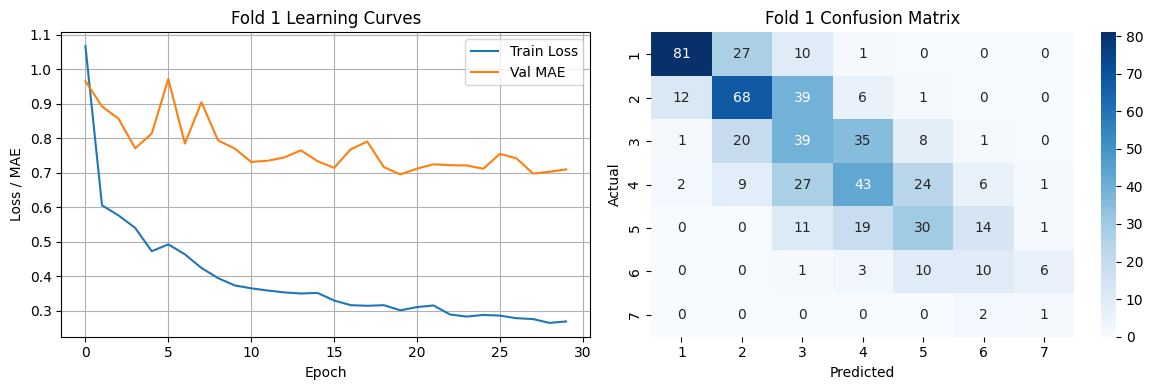

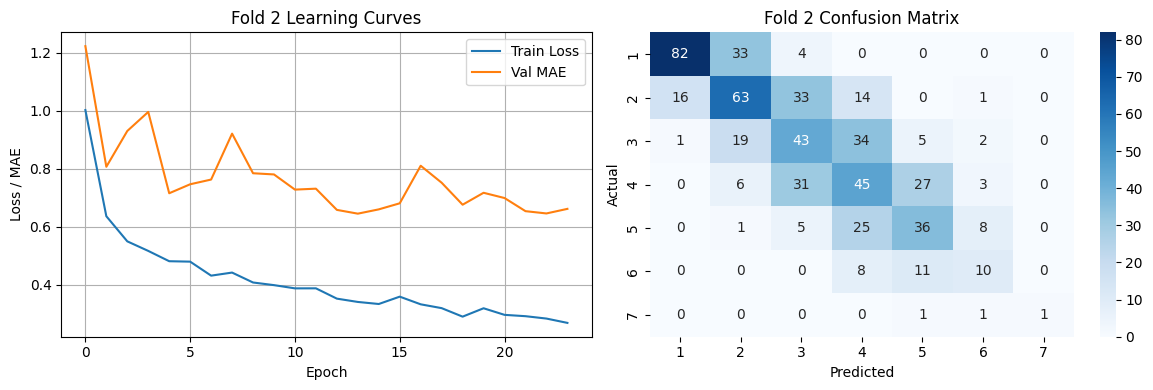

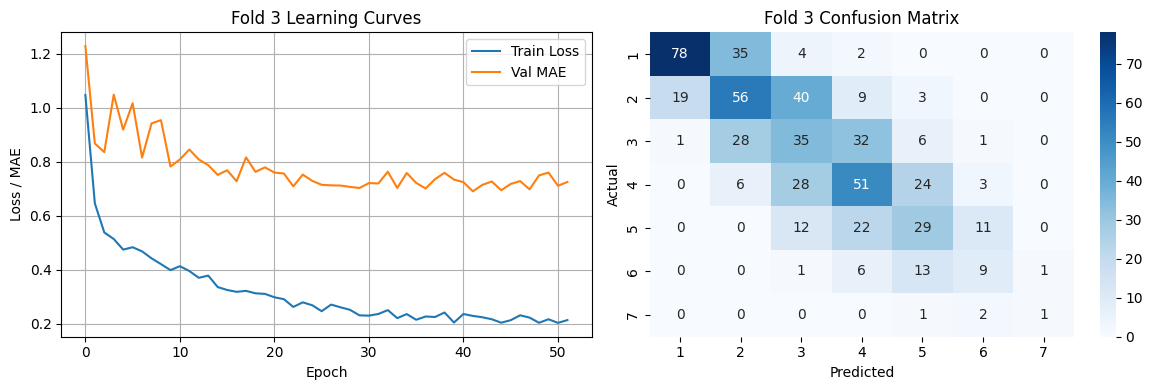

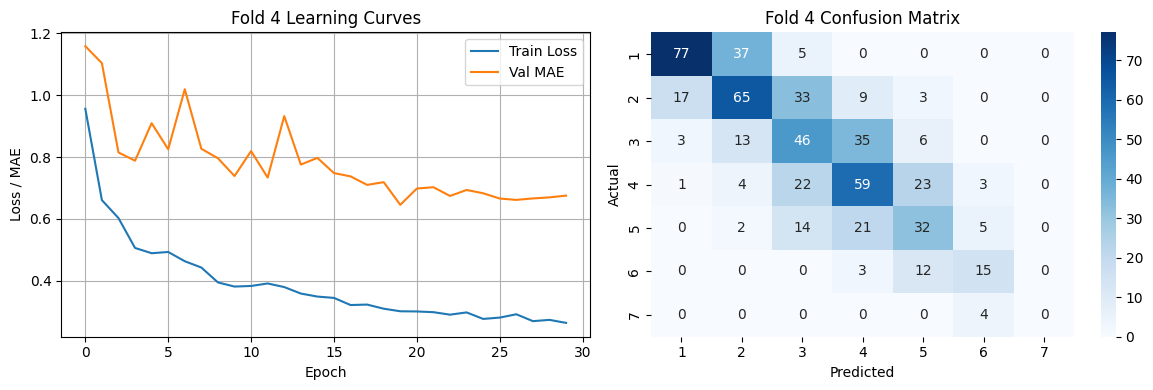

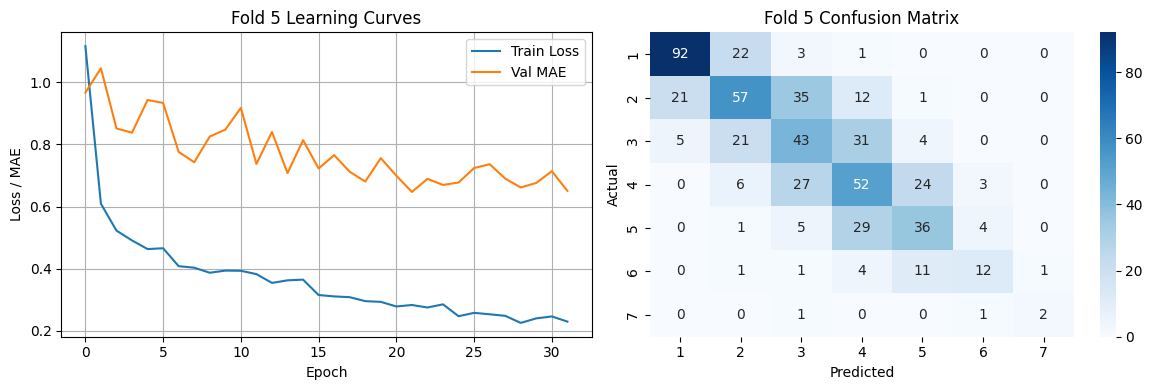

In [9]:
# %% 9. Analyze training: learning curves & confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_fold_analysis(model, fold_id):
    logs = model._train_logs
    train_loss, val_mae = logs['train_loss'], logs['val_mae']
    pv, tv = logs['val_preds'], logs['val_targets']

    # Plot learning curves
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_mae, label="Val MAE")
    plt.title(f"Fold {fold_id} Learning Curves")
    plt.xlabel("Epoch"); plt.ylabel("Loss / MAE")
    plt.legend(); plt.grid(True)

    # Confusion Matrix with ±1 tolerance
    pred_rounded = pv.numpy().round().clip(1,7).astype(int)
    true_labels  = tv.numpy().round().astype(int)
    cm = confusion_matrix(true_labels, pred_rounded, labels=[1,2,3,4,5,6,7])

    plt.subplot(1,2,2)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(1,8), yticklabels=range(1,8))
    plt.title(f"Fold {fold_id} Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# Plot for each fold
for i, model in enumerate(fold_models, 1):
    plot_fold_analysis(model, i)

FINAL TEST SET EVALUATION
Test MAE: 0.694
Test Acc (±0): 46.9%
Test Acc (±1): 90.9%


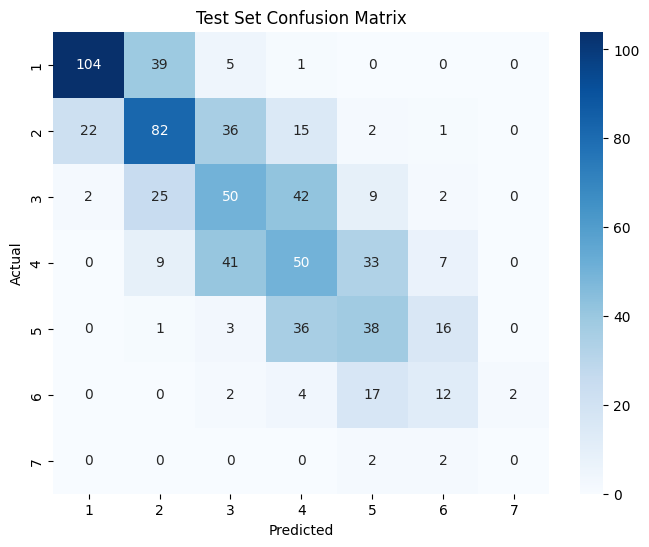


📊 Performance Comparison:
CV MAE: 0.665 | Test MAE: 0.694
Difference: 0.029
✅ Excellent generalization - CV and test results are very close!


In [10]:
# %% 10 Final evaluation on held-out test set
print("="*50)
print("FINAL TEST SET EVALUATION")
print("="*50)

# Create test loader
test_loader = DataLoader(
    ShapeDataset(df_test, val_tf),  # Use val_tf (no augmentation)
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

# Evaluate best model on test set
best_model.eval()
test_preds, test_targs = [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        test_preds.append(best_model(x).cpu())
        test_targs.append(y.cpu())

test_preds = torch.cat(test_preds)
test_targs = torch.cat(test_targs)

# Calculate metrics
test_mae = mae(test_preds, test_targs)
test_acc = acc_std(test_preds, test_targs)
test_tol = acc_tol(test_preds, test_targs)

print(f"Test MAE: {test_mae:.3f}")
print(f"Test Acc (±0): {test_acc:.1f}%")
print(f"Test Acc (±{TOL}): {test_tol:.1f}%")

# Plot test set confusion matrix
plt.figure(figsize=(8, 6))
pred_rounded = test_preds.numpy().round().clip(1,7).astype(int)
true_labels = test_targs.numpy().round().astype(int)
cm = confusion_matrix(true_labels, pred_rounded, labels=[1,2,3,4,5,6,7])

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=range(1,8), yticklabels=range(1,8))
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Compare CV vs Test performance
print(f"\n📊 Performance Comparison:")
print(f"CV MAE: {np.mean(mae_list):.3f} | Test MAE: {test_mae:.3f}")
print(f"Difference: {abs(test_mae - np.mean(mae_list)):.3f}")
if abs(test_mae - np.mean(mae_list)) < 0.05:
    print("✅ Excellent generalization - CV and test results are very close!")
elif abs(test_mae - np.mean(mae_list)) < 0.1:
    print("✅ Good generalization - minor difference between CV and test")
else:
    print("⚠️ Larger gap between CV and test - might indicate overfitting")

In [11]:
# %% 11. Grad-CAM utils
def grad_cam(model, x, tgt_layer):
    acts, grads = [], []
    def fwd(m, i, o): acts.append(o)
    def bwd(m, gi, go): grads.append(go[0])
    h1 = tgt_layer.register_forward_hook(fwd)
    h2 = tgt_layer.register_backward_hook(bwd)
    model.zero_grad()
    out = model(x)
    out.backward(torch.ones_like(out))
    a, g = acts[0].squeeze(0), grads[0].squeeze(0)
    w = g.mean(dim=(1, 2))
    cam = torch.relu((w[:, None, None] * a).sum(0))
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    h1.remove(); h2.remove()
    return cam.detach().cpu().numpy()

def show_heat(img_t, cam):
    img = img_t.squeeze().cpu().numpy()
    cam = cv2.resize(cam, img.shape[::-1])
    heat = cv2.applyColorMap((cam * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)
    return (0.5 * heat + np.stack([img * 255] * 3, 2)).astype(np.uint8)

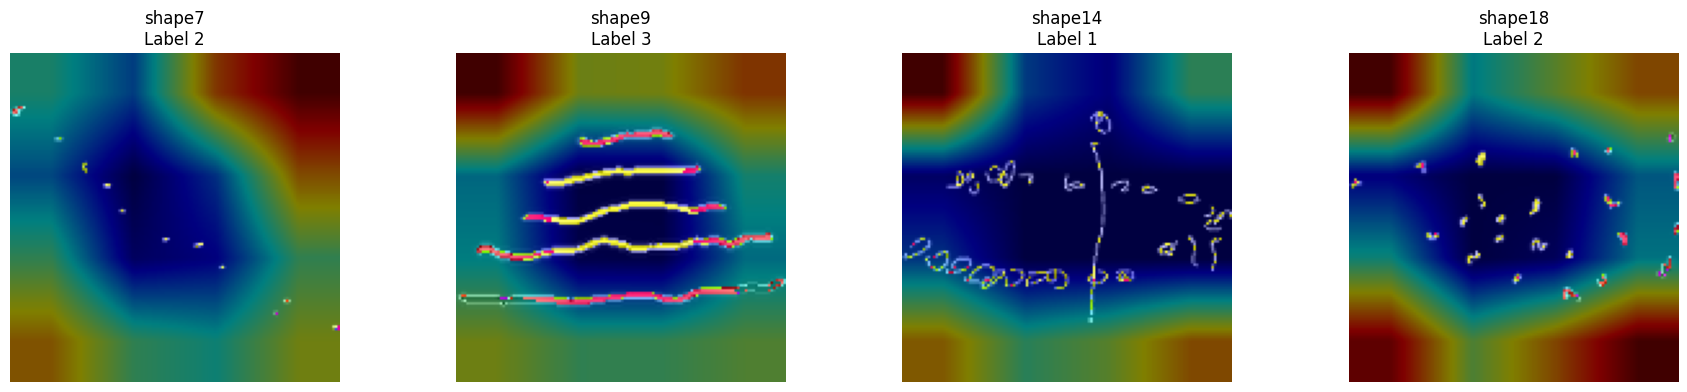

In [12]:
# %% 12. Grad-CAM demo – one example per shape group
tgt_layer = best_model.backbone.layer4

fig_idx = 1
plt.figure(figsize=(18, 4))

for shape_name in ["shape7", "shape9", "shape14", "shape18"]:
    # rows whose img_path contains this shape folder
    sub = df[df["img_path"].str.contains(f"/{shape_name}/")]
    if sub.empty:
        continue                       # skip if that shape wasn't in the merge
    row = sub.sample(1, random_state=SEED).iloc[0]

    # load + transform
    img_raw = cv2.imread(row.img_path, cv2.IMREAD_GRAYSCALE)
    img_t   = val_tf(image=img_raw)["image"].float() / 255.0
    x       = img_t.unsqueeze(0).to(device)

    # Grad-CAM
    cam = grad_cam(best_model, x, tgt_layer)
    vis = show_heat(img_t, cam)

    # plot
    plt.subplot(1, 4, fig_idx)
    plt.imshow(vis); plt.axis("off")
    plt.title(f"{shape_name}\nLabel {int(row.label)}")
    fig_idx += 1

plt.tight_layout(); plt.show()


📍 Image: 10823.png
📊 Raw prediction: 2.155
🎯 Rounded score: 2


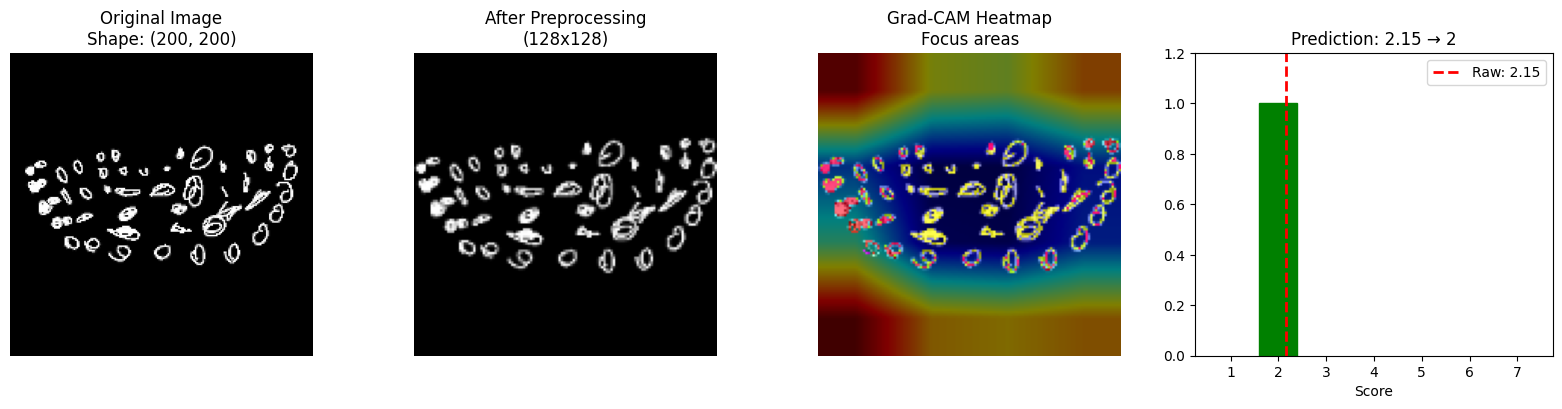


💡 Interpretation:
• Strong activation areas detected - model is confident about specific features
• High confidence: prediction 2.15 is close to 2


'\ntest_images = [\n    "/content/drive/MyDrive/test1.png",\n    "/content/drive/MyDrive/test2.png",\n    "/content/drive/MyDrive/test3.png"\n]\n\nfor img_path in test_images:\n    if os.path.exists(img_path):\n        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)\n        img_t = val_tf(image=img)["image"].float() / 255.0\n        x = img_t.unsqueeze(0).to(device)\n        \n        with torch.no_grad():\n            pred = best_model(x).cpu().item()\n        \n        print(f"{img_path.split(\'/\')[-1]}: {pred:.3f} → {round(pred)}")\n'

In [13]:
# %% Test single image with prediction and Grad-CAM

# ===== CHANGE THIS PATH TO YOUR IMAGE =====
test_image_path = "/content/10823.png"

# Load and preprocess the image
img_raw = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
if img_raw is None:
    print(f"Error: Could not load image from {test_image_path}")
else:
    # Apply the same preprocessing as validation
    img_transformed = val_tf(image=img_raw)["image"].float() / 255.0
    x = img_transformed.unsqueeze(0).to(device)

    # Get prediction
    best_model.eval()
    with torch.no_grad():
        prediction = best_model(x).cpu().item()

    rounded_pred = round(prediction)

    print("="*50)
    print(f"📍 Image: {test_image_path.split('/')[-1]}")
    print(f"📊 Raw prediction: {prediction:.3f}")
    print(f"🎯 Rounded score: {rounded_pred}")
    print("="*50)

    # Generate Grad-CAM
    tgt_layer = best_model.backbone.layer4
    cam = grad_cam(best_model, x, tgt_layer)
    heatmap_vis = show_heat(img_transformed, cam)

    # Visualize everything
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    # 1. Original image
    axes[0].imshow(img_raw, cmap='gray')
    axes[0].set_title(f"Original Image\nShape: {img_raw.shape}")
    axes[0].axis('off')

    # 2. After smart crop & resize
    axes[1].imshow(img_transformed.squeeze().cpu().numpy(), cmap='gray')
    axes[1].set_title(f"After Preprocessing\n({IMG_SIZE}x{IMG_SIZE})")
    axes[1].axis('off')

    # 3. Grad-CAM heatmap
    axes[2].imshow(heatmap_vis)
    axes[2].set_title(f"Grad-CAM Heatmap\nFocus areas")
    axes[2].axis('off')

    # 4. Prediction bar chart
    scores = list(range(1, 8))
    bars = axes[3].bar(scores, [0]*7, color='lightgray')
    bars[rounded_pred-1].set_color('green')
    bars[rounded_pred-1].set_height(1)

    # Show raw prediction as a red line
    axes[3].axvline(x=prediction, color='red', linestyle='--', linewidth=2, label=f'Raw: {prediction:.2f}')
    axes[3].set_ylim(0, 1.2)
    axes[3].set_xlabel('Score')
    axes[3].set_title(f'Prediction: {prediction:.2f} → {rounded_pred}')
    axes[3].set_xticks(scores)
    axes[3].legend()

    plt.tight_layout()
    plt.show()

    # Interpretation
    print("\n💡 Interpretation:")
    if cam.max() > 0.7:
        print("• Strong activation areas detected - model is confident about specific features")
    else:
        print("• Diffuse activation - model is using broader image features")

    if abs(prediction - rounded_pred) < 0.2:
        print(f"• High confidence: prediction {prediction:.2f} is close to {rounded_pred}")
    else:
        print(f"• Borderline case: prediction {prediction:.2f} is between {int(prediction)} and {int(prediction)+1}")

# ===== Test multiple images at once (optional) =====
# Uncomment and modify paths to test multiple images
"""
test_images = [
    "/content/drive/MyDrive/test1.png",
    "/content/drive/MyDrive/test2.png",
    "/content/drive/MyDrive/test3.png"
]

for img_path in test_images:
    if os.path.exists(img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_t = val_tf(image=img)["image"].float() / 255.0
        x = img_t.unsqueeze(0).to(device)

        with torch.no_grad():
            pred = best_model(x).cpu().item()

        print(f"{img_path.split('/')[-1]}: {pred:.3f} → {round(pred)}")
"""

RuntimeError: You saved only a state_dict, but MODEL_PY/MODEL_CLASS were not provided.
Set MODEL_PY to a .py file containing your EXACT model class and MODEL_CLASS to its class name.